In [14]:
import pickle
import math

import pandas as pd
import matplotlib.pyplot as plt

# Data Loading

In [5]:
with open("data/splited_data.pickle", "rb") as file:
    data = pickle.load(file)
    X_train = data["X_train"]
    y_train = data["y_train"]

In [6]:
X_train.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1648,x,s,w,f,n,f,w,b,h,t,...,f,w,w,p,w,o,e,n,s,g
5183,x,s,b,t,f,f,c,b,w,t,...,s,w,w,p,w,o,p,h,v,u
304,x,y,w,t,l,f,c,b,g,e,...,s,w,w,p,w,o,p,k,s,g
5112,f,y,y,f,f,f,c,b,p,e,...,k,b,p,p,w,o,l,h,y,p
1371,x,s,n,f,n,f,w,b,p,t,...,s,w,w,p,w,o,e,k,s,g


In [7]:
y_train.head()

1648    1
5183    0
304     1
5112    0
1371    1
Name: class, dtype: int64

# Descreptive Analysis

## Overview of the Atributes

In [8]:
X_train.shape[1]

22

In [9]:
X_overview = X_train.apply(lambda x: x.unique()).to_frame("Unique Values")
X_overview["Number of Unique Values"] = X_overview["Unique Values"].apply(len)
X_overview

,Unique Values,Number of Unique Values
cap-shape,"[x, f, b, k, s, c]",6
cap-surface,"[s, y, f, g]",4
cap-color,"[w, b, y, n, g, e, p, u, r, c]",10
bruises,"[f, t]",2
odor,"[n, f, l, a, c, s, y, p, m]",9
gill-attachment,"[f, a]",2
gill-spacing,"[w, c]",2
gill-size,"[b, n]",2
gill-color,"[h, w, g, p, b, k, n, e, u, y, o, r]",12
stalk-shape,"[t, e]",2


In [10]:
one_hot_attributes = X_overview["Number of Unique Values"].sub(1).sum()
one_hot_attributes

95

## Information Gain

In this part we will be analysing the contribution of each attribute to turn our target variable more homogenous. When we want to make a class prediction, we are interested in find data purer data segments, and by doing that maximising our probability of getting our prediction right. So, by looking at the attributes contribution to segmentating our target variable into more homogenous set, we can identify those that would be more helpfull to class prediction.

We will measure this capability with information gain. This implementation of information gain will be based in the entropy metric.

In [11]:
def compute_entropy(x):
    if x[1] == 0 or x[0] == 0:
        return 0
    else:
        return - x[0] * math.log(x[0]) - x[1] * math.log(x[1])

In [12]:
def compute_information_gain(x, y):
    father_entropy = y.value_counts(normalize=True).to_frame().apply(compute_entropy, axis=0).iloc[0]
    
    tab = pd.crosstab(x, y)
    
    probs = tab.div(tab.sum(axis=1), axis=0)
    inf = probs.apply(compute_entropy, axis=1)
    
    totals = tab.sum(axis=1)
    shares = totals.div(totals.sum())
    
    sons_entropy = shares.mul(inf).sum()                                                              
    
    return father_entropy - sons_entropy

In [15]:
information_gain = dict()
X_cols = X_train.columns
for col in X_cols:
    information_gain[col] = compute_information_gain(x=X_train[col], y=y_train)
information_gain = pd.Series(information_gain)

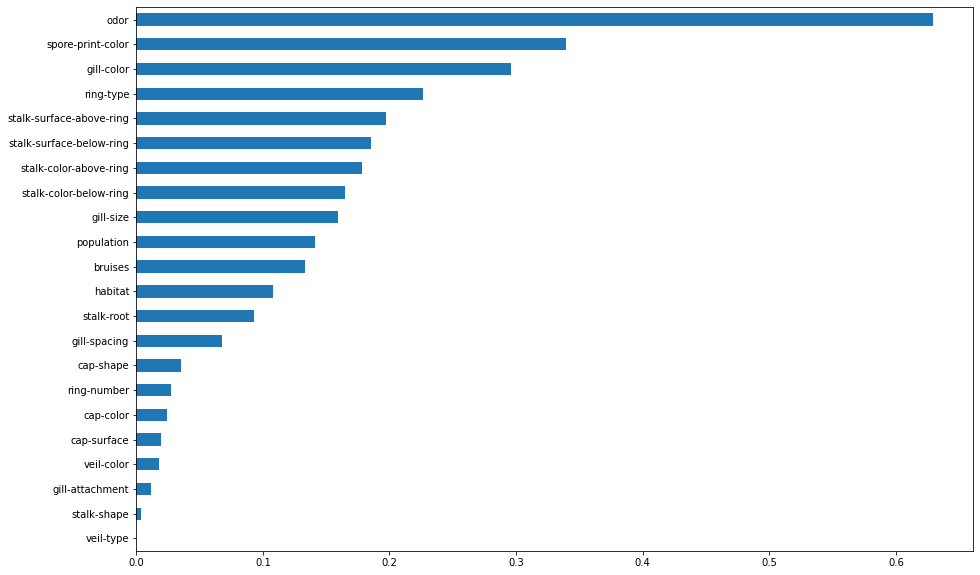

In [16]:
information_gain.sort_values(inplace=True)
information_gain.plot(kind="barh", figsize=[15, 10]);

## Atributes distribution regarding the target variable

Next we will take a more desgregated perspective on the data and will analyze the joint distribution between our attributes and target variable. To make it easer to analyse this information we will be ordering the plots respective to their information gain. 

In [19]:
def stacked_bar(X_col, y, percent=False):
    tab = pd.crosstab(X_col, y)
    if percent:
        tab = tab.apply(lambda x: x*100/sum(x), axis=1)
    tab.sort_values(by=[1, 0], inplace=True)    
    tab.plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title(X_col.name)
    plt.xlabel(None)

In [20]:
def stacked_subplots(X, y, percent, cols, n_rows=5, n_cols=5, figsize=[20, 20]):
    plt.figure(figsize=figsize)
    for i, col in enumerate(cols):
        plt.subplot(n_rows, n_cols, i + 1)
        stacked_bar(X_col=X[col], y=y, percent=percent)
    plt.show()

In [26]:
plot_order = information_gain.sort_values(ascending=False).index

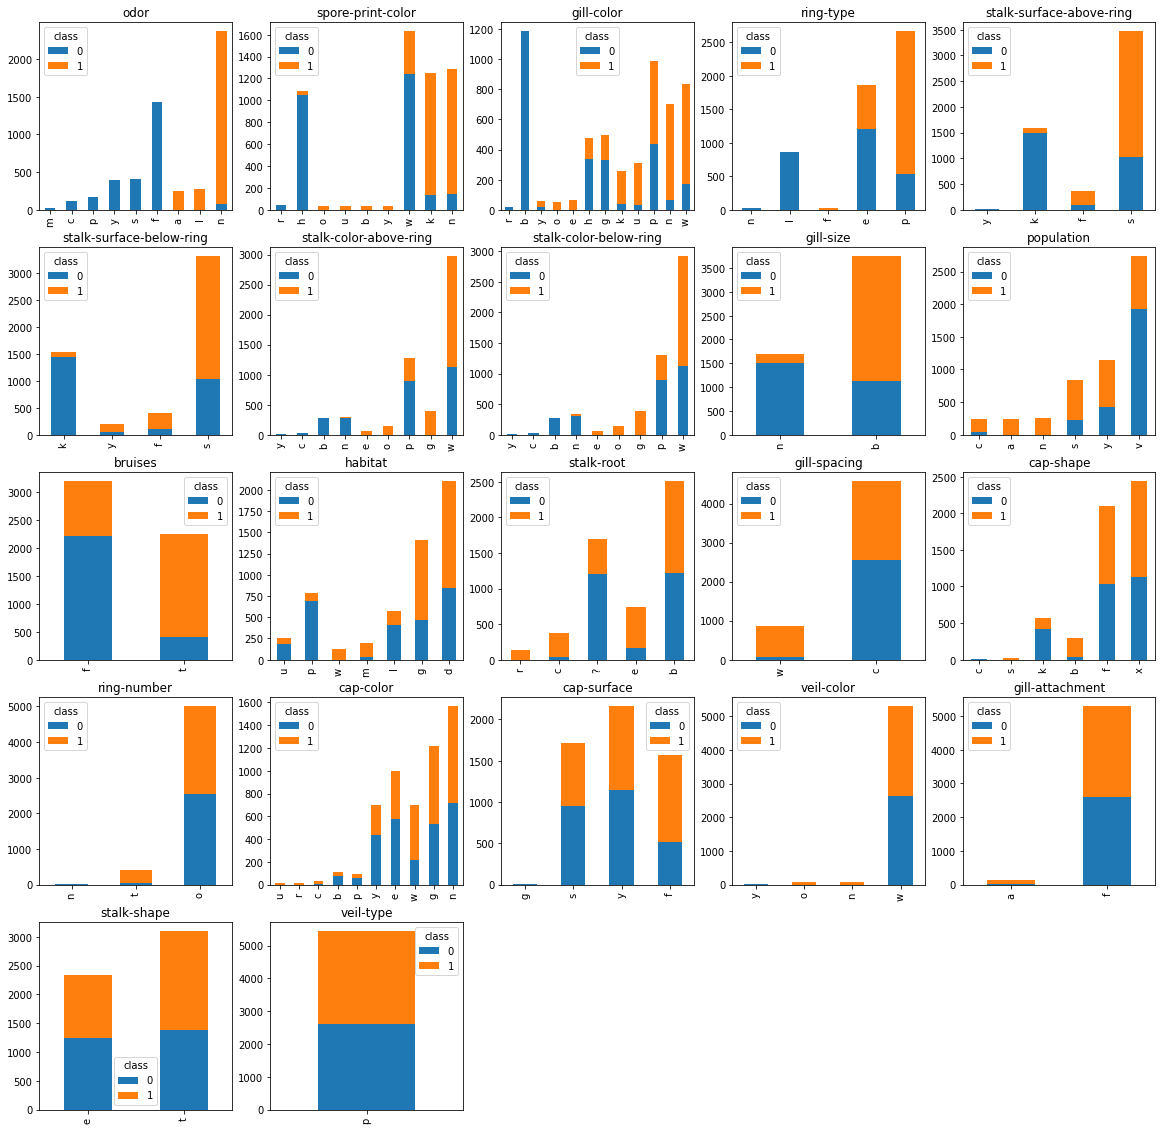

In [27]:
stacked_subplots(X=X_train, y=y_train, percent=False, cols=plot_order)

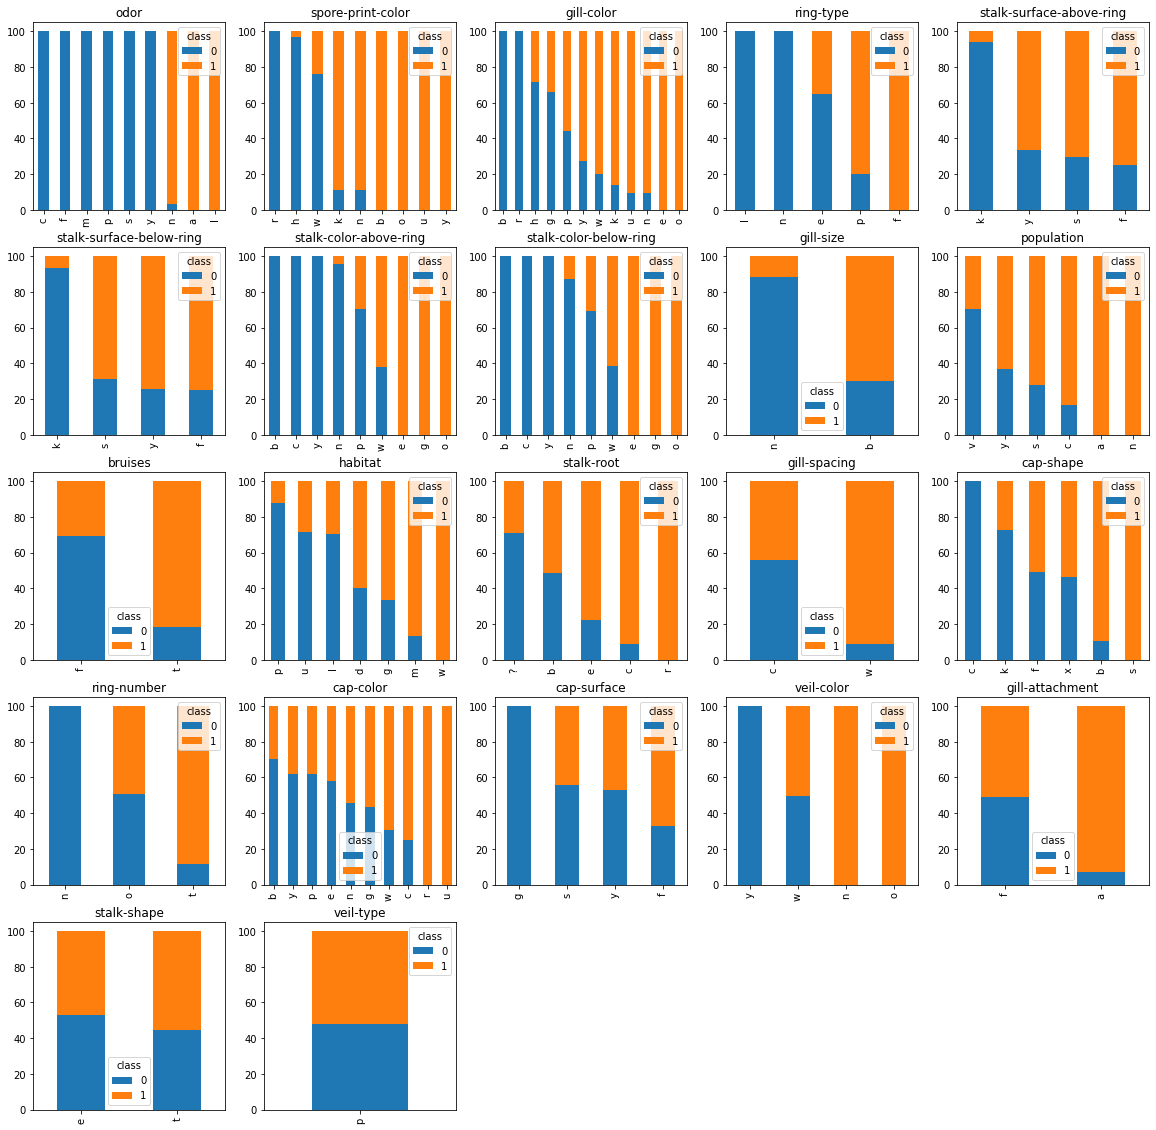

In [28]:
stacked_subplots(X=X_train, y=y_train, percent=True, cols=plot_order)